Starting simulation at t=0. s for a duration of 50. ms
50. ms (100%) simulated in < 1s


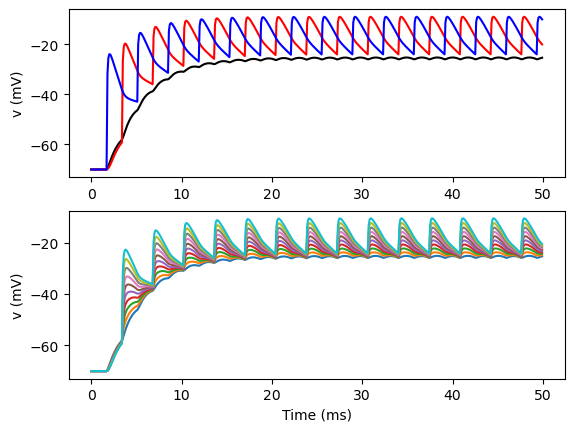

In [1]:
from brian2 import *

# Morphology
morpho = Soma(30*um)
morpho.L = Cylinder(diameter=1*um, length=100*um, n=50)
morpho.R = Cylinder(diameter=1*um, length=100*um, n=50)

# Passive channels
gL = 1e-4*siemens/cm**2
EL = -70*mV
Es = 0*mV
eqs = '''
Im = gL*(EL-v) : amp/meter**2
Is = gs*(Es-v) : amp (point current)
gs : siemens
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs,
                       Cm=1*uF/cm**2, Ri=100*ohm*cm, method='exponential_euler')
neuron.v = EL

# Regular inputs
stimulation = NeuronGroup(2, 'dx/dt = 300*Hz : 1', threshold='x>1', reset='x=0',
                          method='euler')
stimulation.x = [0, 0.5]  # Asynchronous

# Synapses
taus = 1*ms
w = 20*nS
S = Synapses(stimulation, neuron, model='''dg/dt = -g/taus : siemens (clock-driven)
                                           gs_post = g : siemens (summed)''',
             on_pre='g += w', method='exact')

S.connect(i=0, j=morpho.L[-1])
S.connect(i=1, j=morpho.R[-1])

# Monitors
mon_soma = StateMonitor(neuron, 'v', record=[0])
mon_L = StateMonitor(neuron.L, 'v', record=True)
mon_R = StateMonitor(neuron.R, 'v',
                     record=morpho.R[-1])

run(50*ms, report='text')

subplot(211)
plot(mon_L.t/ms, mon_soma[0].v/mV, 'k')
plot(mon_L.t/ms, mon_L[morpho.L[-1]].v/mV, 'r')
plot(mon_L.t/ms, mon_R[morpho.R[-1]].v/mV, 'b')
ylabel('v (mV)')
subplot(212)
for x in linspace(0*um, 100*um, 10, endpoint=False):
    plot(mon_L.t/ms, mon_L[morpho.L[x]].v/mV)
xlabel('Time (ms)')
ylabel('v (mV)')
show()
